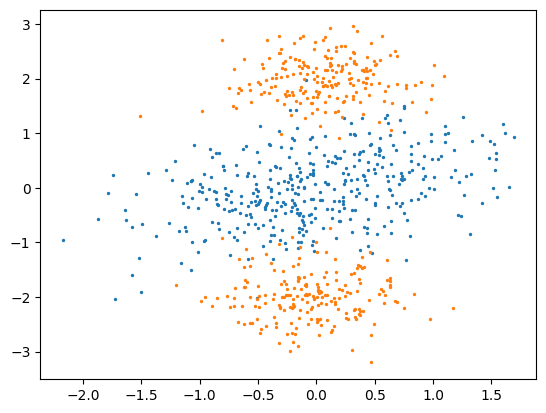

i: 0, loss: 7.053333712716898
i: 1, loss: 50.49504371807771
i: 2, loss: 8.422156200415756
i: 3, loss: 4.466311477468726
i: 4, loss: 9.035874790378665
i: 5, loss: 5.592980966213413
i: 6, loss: 3.755022249343208
i: 7, loss: 3.0382044780522985
i: 8, loss: 1.3956043940409621
i: 9, loss: 0.7598692714056912
i: 10, loss: 2.2704476367402453
i: 11, loss: 1.6920354886562887
i: 12, loss: 0.9797295162602154
i: 13, loss: 0.2504927255309164
i: 14, loss: 0.4933411024525174
i: 15, loss: 0.7345277854347693
i: 16, loss: 0.5717656347653762
i: 17, loss: 0.23570680539174949
i: 18, loss: 0.1277921728778193
i: 19, loss: 0.20995999857898848
i: 20, loss: 0.2625699598832902
i: 21, loss: 0.14378739710573019
i: 22, loss: 0.0664422020027012
i: 23, loss: 0.12685446452029206
i: 24, loss: 0.16238616353475466
i: 25, loss: 0.12410771605223504
i: 26, loss: 0.0818030197648451
i: 27, loss: 0.06673429477353601
i: 28, loss: 0.11693491860913627
i: 29, loss: 0.09794501665444962
i: 30, loss: 0.07105989432485436
i: 31, loss: 0.

In [42]:
import math
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
from flax import linen as nn
from fbs.nn.utils import make_nn_with_time
from fbs.dsb import ipf_loss, simulate_discrete_time

jax.config.update("jax_enable_x64", True)

# Config
nsamples = 400
niters = 500
key = jax.random.PRNGKey(666)
nn_float = jnp.float64
nn_param_init = nn.initializers.xavier_normal()

dt = 0.01
nsteps = 500
T = nsteps * dt
ts = jnp.linspace(0, T, nsteps + 1)


# Toy data
def sample_x0s(_key):
    _, _subkey = jax.random.split(_key)
    ss = jax.random.normal(_subkey, (nsamples, 2)) @ jnp.linalg.cholesky(jnp.array([[0.5, 0.2],
                                                                                    [0.2, 0.5]]))
    return jnp.array([0., 0.]) + ss


def sample_xTs(_key):
    _key, _subkey = jax.random.split(_key)
    _c1 = jnp.array([0., 2.]) + 0.4 * jax.random.normal(_subkey, (int(nsamples / 2), 2))
    _key, _subkey = jax.random.split(_key)
    _c2 = jnp.array([0., -2.]) + 0.4 * jax.random.normal(_subkey, (int(nsamples / 2), 2))
    return jnp.concatenate([_c1, _c2], axis=0)


key, subkey = jax.random.split(key)
x0s = sample_x0s(subkey)
key, subkey = jax.random.split(key)
xTs = sample_xTs(subkey)
plt.scatter(x0s[:, 0], x0s[:, 1], s=2)
plt.scatter(xTs[:, 0], xTs[:, 1], s=2)
plt.show()


# Reference measure Brownian motion
sigma = 1.


# Neural network construction
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=128, param_dtype=nn_float, kernel_init=nn_param_init)(x)
        x = nn.relu(x)
        x = nn.Dense(features=64, param_dtype=nn_float, kernel_init=nn_param_init)(x)
        x = nn.relu(x)
        x = nn.Dense(features=2, param_dtype=nn_float, kernel_init=nn_param_init)(x)
        return jnp.squeeze(x)


mlp = MLP()
key, subkey = jax.random.split(key)
init_param_fwd, _, nn_fwd = make_nn_with_time(mlp, dim_in=2, batch_size=10, time_scale=10, key=subkey)
key, subkey = jax.random.split(key)
init_param_bwd, _, nn_bwd = make_nn_with_time(mlp, dim_in=2, batch_size=10, time_scale=10, key=subkey)

schedule = optax.exponential_decay(1e-2, niters, 0.95)
optimiser = optax.adam(learning_rate=schedule)
f_param = init_param_fwd
b_param = init_param_bwd


# The first IPF iteration
def init_f(x, t, _): return x


@jax.jit
def optax_kernel_init(_b_param, _opt_state, _key):
    _key, _subkey = jax.random.split(_key)
    _x0s = sample_x0s(_subkey)
    _, _subkey = jax.random.split(_key)
    _loss, grad = jax.value_and_grad(ipf_loss)(_b_param, nn_bwd, init_f, _, _x0s, ts, sigma, _subkey)
    updates, _opt_state = optimiser.update(grad, _opt_state, _b_param)
    _b_param = optax.apply_updates(_b_param, updates)
    return _b_param, _opt_state, _loss


@jax.jit
def optax_kernel_fwd(_b_param, _opt_state, _f_param, _key):
    _key, _subkey = jax.random.split(_key)
    _x0s = sample_x0s(_subkey)
    _, _subkey = jax.random.split(_key)
    _loss, grad = jax.value_and_grad(ipf_loss)(_b_param, nn_bwd, nn_fwd, _f_param, _x0s, ts, sigma, _subkey)
    updates, _opt_state = optimiser.update(grad, _opt_state, _b_param)
    _b_param = optax.apply_updates(_b_param, updates)
    return _b_param, _opt_state, _loss


@jax.jit
def optax_kernel_bwd(_f_param, _opt_state, _b_param, _key):
    _key, _subkey = jax.random.split(_key)
    _xTs = sample_xTs(_subkey)
    _, _subkey = jax.random.split(_key)
    _loss, grad = jax.value_and_grad(ipf_loss)(_f_param, nn_fwd, nn_bwd, _b_param, _xTs, ts, sigma, _subkey)
    updates, _opt_state = optimiser.update(grad, _opt_state, _f_param)
    _f_param = optax.apply_updates(_f_param, updates)
    return _f_param, _opt_state, _loss

opt_state = optimiser.init(b_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    b_param, opt_state, loss = optax_kernel_init(b_param, opt_state, subkey)
    print(f'i: {i}, loss: {loss}')

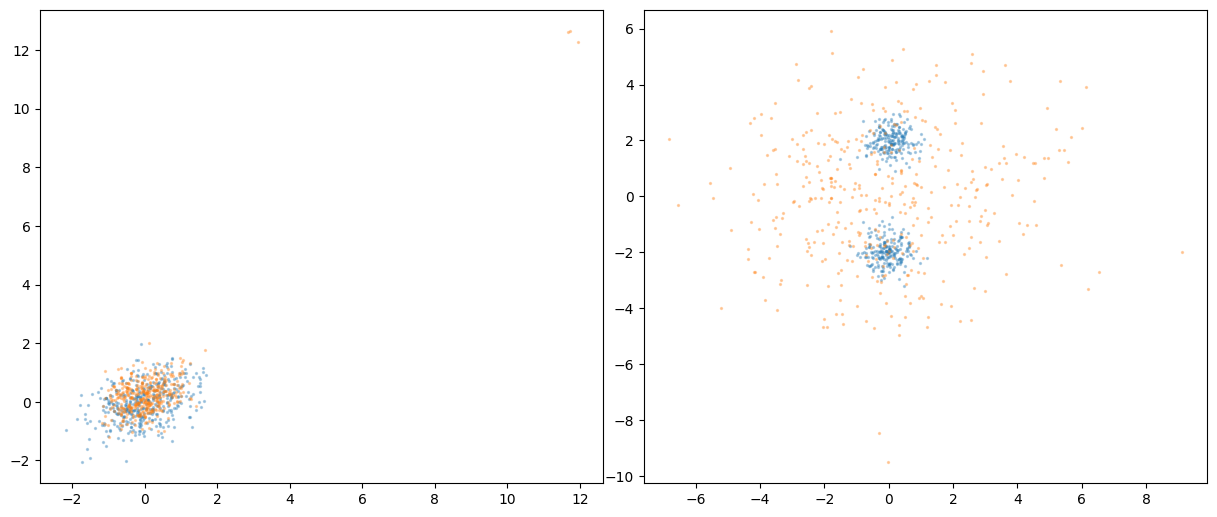

In [43]:
# Test if the reverse is learnt correctly
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(init_f, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [44]:
opt_state = optimiser.init(f_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    f_param, opt_state, loss = optax_kernel_bwd(f_param, opt_state, b_param, subkey)
    print(f'i: {i}, loss: {loss}')

i: 0, loss: 37.54678409756241
i: 1, loss: 30.632483579711643
i: 2, loss: 16.972650508028064
i: 3, loss: 10.559770909703593
i: 4, loss: 7.800191240669287
i: 5, loss: 6.876742362727532
i: 6, loss: 8.152622871607008
i: 7, loss: 5.368553140274256
i: 8, loss: 2.7349042000367114
i: 9, loss: 1.3987851622282008
i: 10, loss: 1.8247125990115602
i: 11, loss: 2.9739912174218506
i: 12, loss: 2.1557916574699405
i: 13, loss: 0.9236941825228049
i: 14, loss: 0.5992662344128389
i: 15, loss: 0.6449254142106806
i: 16, loss: 0.6861113260957067
i: 17, loss: 0.7152912801476148
i: 18, loss: 0.5694772071490319
i: 19, loss: 0.3481381895926129
i: 20, loss: 0.24739310304785528
i: 21, loss: 0.3416822860698108
i: 22, loss: 0.4319990166669268
i: 23, loss: 0.33509339497103097
i: 24, loss: 0.18255385010535952
i: 25, loss: 0.10823440521364201
i: 26, loss: 0.13027847630182585
i: 27, loss: 0.17974747929490842
i: 28, loss: 0.19264665392107452
i: 29, loss: 0.17900609813528556
i: 30, loss: 0.15213526549022727
i: 31, loss: 0

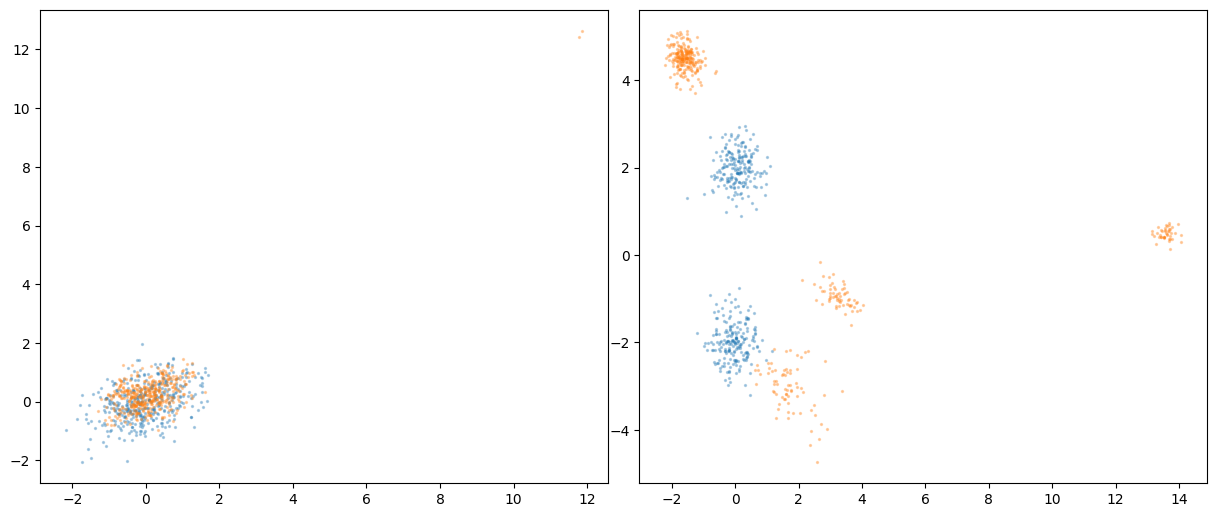

In [45]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [46]:
opt_state = optimiser.init(b_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    b_param, opt_state, loss = optax_kernel_fwd(b_param, opt_state, f_param, subkey)
    print(f'i: {i}, loss: {loss}')

i: 0, loss: 0.025162752374186092
i: 1, loss: 10.171559155584358
i: 2, loss: 1.505715202551749
i: 3, loss: 4.784970324202711
i: 4, loss: 3.2526704520960816
i: 5, loss: 0.8948899867351552
i: 6, loss: 0.9945765060764015
i: 7, loss: 2.1868840617762606
i: 8, loss: 2.3466510281955184
i: 9, loss: 1.5732784703799982
i: 10, loss: 0.7319720445405602
i: 11, loss: 0.1932865068752461
i: 12, loss: 0.24386303557118713
i: 13, loss: 0.5785939104152531
i: 14, loss: 0.5751318717407263
i: 15, loss: 0.3393033963940946
i: 16, loss: 0.19525164349683355
i: 17, loss: 0.24312769303067594
i: 18, loss: 0.21534856867487676
i: 19, loss: 0.17120078329349353
i: 20, loss: 0.12357878856800421
i: 21, loss: 0.0873450478532364
i: 22, loss: 0.09063420461156797
i: 23, loss: 0.10428564618396875
i: 24, loss: 0.12358672895269157
i: 25, loss: 0.12217974585797417
i: 26, loss: 0.08761840016541125
i: 27, loss: 0.06874635903840544
i: 28, loss: 0.07744444574604116
i: 29, loss: 0.09199194780047497
i: 30, loss: 0.07374240310426036
i: 

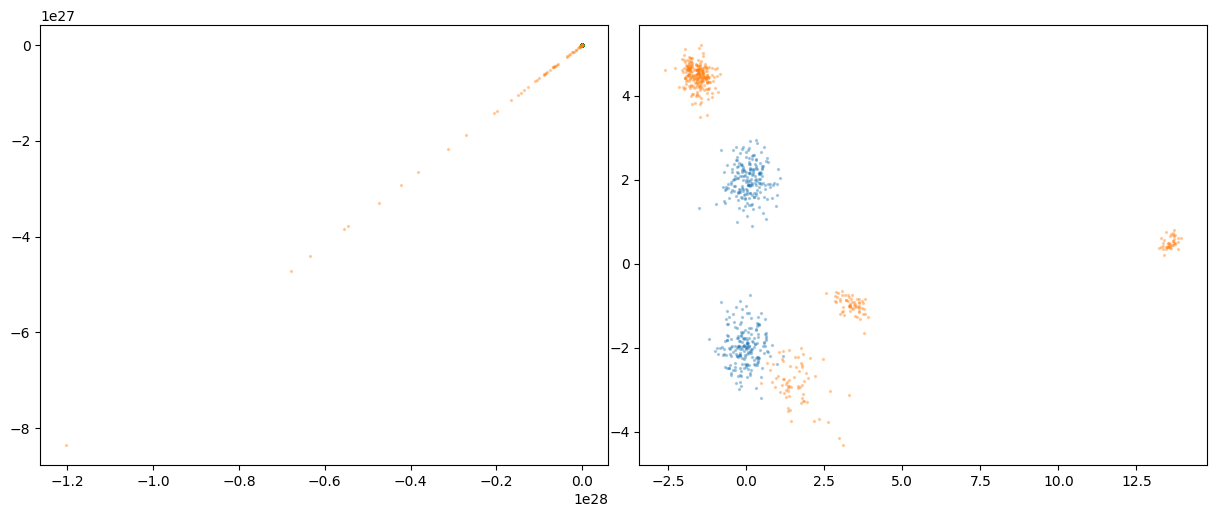

In [47]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [48]:
opt_state = optimiser.init(f_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    f_param, opt_state, loss = optax_kernel_bwd(f_param, opt_state, b_param, subkey)
    print(f'i: {i}, loss: {loss}')

i: 0, loss: 0.02224553338146184
i: 1, loss: 9.641540116842837
i: 2, loss: 2.6273263522935038
i: 3, loss: 5.119257657734248
i: 4, loss: 2.432774754378133
i: 5, loss: 0.5402049593315198
i: 6, loss: 1.141239220777762
i: 7, loss: 2.276688342383184
i: 8, loss: 2.4280526015734822
i: 9, loss: 1.6899346563052189
i: 10, loss: 0.9404697814249547
i: 11, loss: 0.6909071281087025
i: 12, loss: 0.810393868751461
i: 13, loss: 0.9972460464712368
i: 14, loss: 1.0399134902751974
i: 15, loss: 0.8322923018647018
i: 16, loss: 0.4186570268297513
i: 17, loss: 0.12102648513134713
i: 18, loss: 0.2965802222606652
i: 19, loss: 0.4344130043407115
i: 20, loss: 0.33024898371204064
i: 21, loss: 0.23119313920467327
i: 22, loss: 0.20278842470329192
i: 23, loss: 0.18784104729138407
i: 24, loss: 0.17833675939578827
i: 25, loss: 0.1585465030447103
i: 26, loss: 0.1309039269875486
i: 27, loss: 0.10397418021104052
i: 28, loss: 0.08584127166375084
i: 29, loss: 0.0758135231463858
i: 30, loss: 0.0725117805515131
i: 31, loss: 0.

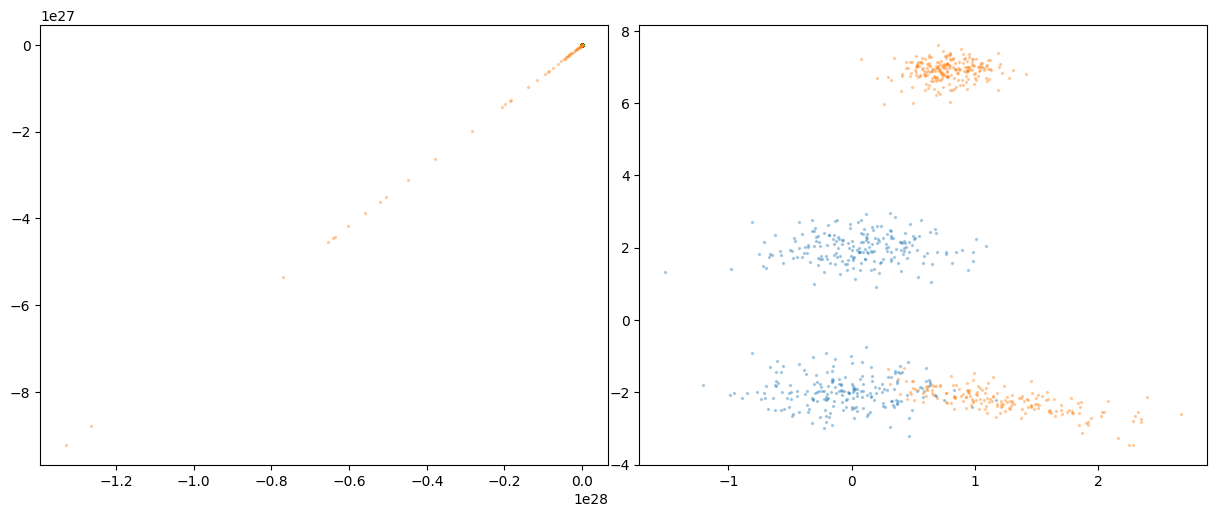

In [49]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [50]:
opt_state = optimiser.init(b_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    b_param, opt_state, loss = optax_kernel_fwd(b_param, opt_state, f_param, subkey)
    print(f'i: {i}, loss: {loss}')

i: 0, loss: 0.027248924402260698
i: 1, loss: 2.7492663905795833
i: 2, loss: 0.3218441549915316
i: 3, loss: 0.37113320997042903
i: 4, loss: 0.9129860384558163
i: 5, loss: 0.7320446049507865
i: 6, loss: 0.49940626014454104
i: 7, loss: 0.3592008997275648
i: 8, loss: 0.20697302061290948
i: 9, loss: 0.14988951373358833
i: 10, loss: 0.1310936712968691
i: 11, loss: 0.1417955511916263
i: 12, loss: 0.15247711790208168
i: 13, loss: 0.12274421142123498
i: 14, loss: 0.07759582493249001
i: 15, loss: 0.05895961493103469
i: 16, loss: 0.055071629264436435
i: 17, loss: 0.04972703506641285
i: 18, loss: 0.05150839440846767
i: 19, loss: 0.05334573168015518
i: 20, loss: 0.04632408902484306
i: 21, loss: 0.04489835926827481
i: 22, loss: 0.04259210411624342
i: 23, loss: 0.03890352419935701
i: 24, loss: 0.038480573042819294
i: 25, loss: 0.035090810798115366
i: 26, loss: 0.03145000141555791
i: 27, loss: 0.03261900567410437
i: 28, loss: 0.029038009759314636
i: 29, loss: 0.030416886683325848
i: 30, loss: 0.029144

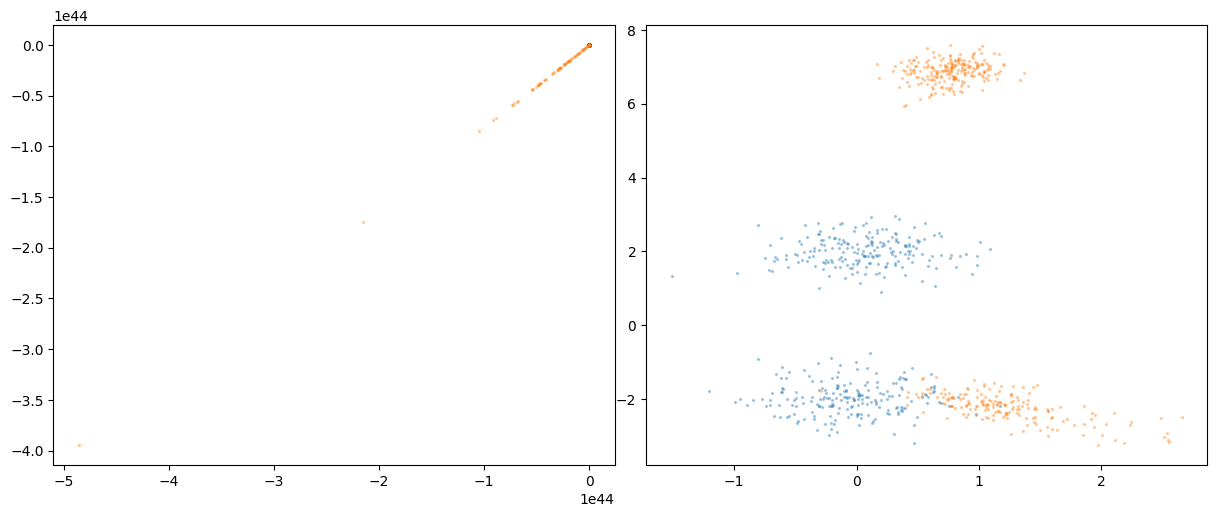

In [51]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()